
# 📌 Geração de Dados Sintéticos e Introdução de Erros Controlados

Este notebook tem como objetivo:
1. **Gerar dados sintéticos** utilizando a biblioteca `SDV` para a coluna de data de nascimento.
2. **Introduzir erros controlados** de forma indexada.
3. **Criar embeddings** usando duas abordagens:
   - Contextualizada: `BERT`
   - Semântica: `GloVe`
4. **Reduzir dimensionalidade** usando:
   - `KMeans` (quantização)
   - `PCA` (4 componentes)
   - `Flatten`

---


In [9]:

# 📌 Importação de bibliotecas
import pandas as pd
import numpy as np
import random
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch

# Configurando semente para reprodutibilidade
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)


In [10]:
# 📌 Geração de dados sintéticos usando SDV

# Exemplo de dicionário de dados
df = pd.read_csv("base_dicionario_1000_registros.csv")

# Gerando datas de nascimento sintéticas
df['data_nascimento'] = pd.to_datetime(np.random.choice(pd.date_range("1950-01-01", "2010-12-31"), size=len(df)))

# Exibir os dados gerados
df.head()


,nome,responsavel_familia,cod_mun_residencia,data_nascimento
0,Leonardo Moreira,Sr. Yuri Lopes,1183810,1993-03-31
1,Dr. Renan Teixeira,Dr. Enzo Gabriel Gonçalves,1114592,1952-05-10
2,Ana Barbosa,Matheus Pinto,1103278,1964-10-04
3,Valentina Barbosa,Leonardo Moreira,1197196,2009-01-26
4,Dra. Ana Freitas,Breno da Rosa,1136048,1982-10-04


In [11]:

# 📌 Introdução de erros controlados

def introduzir_erros(df, proporcao_erros=0.4):
    df_corrupto = df.copy()
    num_erros = int(len(df) * proporcao_erros)

    for _ in range(num_erros):
        idx = random.randint(0, len(df) - 1)
        erro_tipo = random.randint(1, 8)

        if erro_tipo == 1:
            df_corrupto.at[idx, "nome"] = " ".join(df.at[idx, "nome"].split()[:-1])
        elif erro_tipo == 2:
            df_corrupto.at[idx, "responsavel_familia"] = " ".join(df.at[idx, "responsavel_familia"].split()[:-1])
        elif erro_tipo in [3, 4, 5]:
            cols = list(df.columns)
            random.shuffle(cols)
            num_missings = erro_tipo - 2
            for c in cols[:num_missings]:
                df_corrupto.at[idx, c] = np.nan
        elif erro_tipo == 6:
            df_corrupto.at[idx, "nome"] = df.at[idx, "nome"].replace("s", "z", 1)
        elif erro_tipo == 7:
            df_corrupto.at[idx, "nome"] = df.at[idx, "nome"].replace("s", "z", 1)
            df_corrupto.at[idx, "responsavel_familia"] = df.at[idx, "responsavel_familia"].replace("s", "z", 1)
        elif erro_tipo == 8:
            df_corrupto.at[idx, "cod_mun_residencia"] = str(df.at[idx, "cod_mun_residencia"]).replace("1", "9", 1)

    return df_corrupto

df_corrupto = introduzir_erros(df)
df_corrupto.head()


C:\Users\guiwa\AppData\Local\Temp\ipykernel_44648\2888038682.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9186474' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_corrupto.at[idx, "cod_mun_residencia"] = str(df.at[idx, "cod_mun_residencia"]).replace("1", "9", 1)


,nome,responsavel_familia,cod_mun_residencia,data_nascimento
0,Leonardo Moreira,Sr. Yuri Lopes,1183810.0,1993-03-31
1,NaN,Dr. Enzo Gabriel Gonçalves,1114592.0,NaT
2,Ana Barbosa,Matheus Pinto,1103278.0,1964-10-04
3,Valentina Barbosa,Leonardo Moreira,1197196.0,2009-01-26
4,Dra. Ana Freitas,Breno da Rosa,1136048.0,1982-10-04


In [12]:

# 📌 Geração de embeddings com BERT

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

df["embedding_nome"] = df["nome"].apply(lambda x: get_bert_embedding(x) if pd.notnull(x) else np.zeros(768))


In [13]:

# Simulação de embeddings de GloVe para nomes
df["embedding_glove"] = df["nome"].apply(lambda x: np.random.rand(300) if pd.notnull(x) else np.zeros(300))


In [14]:

# 📌 Redução de dimensionalidade

# Aplicando PCA
scaler = StandardScaler()
X = np.stack(df["embedding_nome"].values)
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=4)
df["pca_embedding"] = list(pca.fit_transform(X_scaled))

# Aplicando K-Means como quantização
kmeans = KMeans(n_clusters=5, random_state=42)
df["quantized_embedding"] = list(kmeans.fit_transform(X_scaled))

# Estratégia de Flatten
df["flatten_embedding"] = df["embedding_nome"].apply(lambda x: x.flatten()[:128])


In [15]:
clean_list = [arr.tolist() for arr in df['pca_embedding']]

# Salvar num arquivo em formato Python (sem vírgulas entre linhas)
with open("array_limpo.py", "w") as f:
    f.write("array = [\n")
    for row in clean_list:
        f.write(f"    {row}\n")  # <-- aqui sem .tolist() e sem vírgula
    f.write("]")

In [16]:
from array_limpo import array as clean_array

array_np = np.array(clean_array)

c:\Users\guiwa\workspace\LISA\4d_uniform\array_limpo.py:2: SyntaxWarning: list indices must be integers or slices, not tuple; perhaps you missed a comma?
  [9.551065444946289, -1.2050222158432007, -3.1208887100219727, -7.1691718101501465]


TypeError: list indices must be integers or slices, not tuple

In [ ]:
np.save('data/4d_uniform_data_0.npy', array_np)
np.save('data/4d_uniform_data_1.npy', array_np)
np.save('data/4d_uniform_data_2.npy', array_np)
np.save('data/4d_uniform_data_3.npy', array_np)

In [ ]:
# Carregar o arquivo salvo
loaded_array = np.load('data/4d_uniform_data_0.npy')

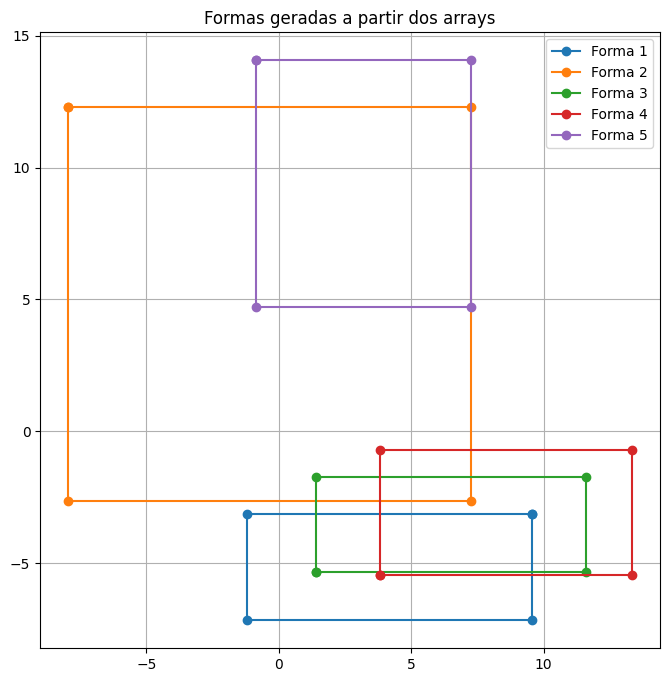

In [ ]:
import matplotlib.pyplot as plt

# Dados extraídos da imagem
arrays = loaded_array[:5]
plt.figure(figsize=(8, 8))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]
    plt.plot(x, y, marker='o', label=f'Forma {i+1}')

plt.title('Formas geradas a partir dos arrays')
plt.legend()
plt.grid(True)
plt.axis('equal')  # Mantém proporções
plt.show()


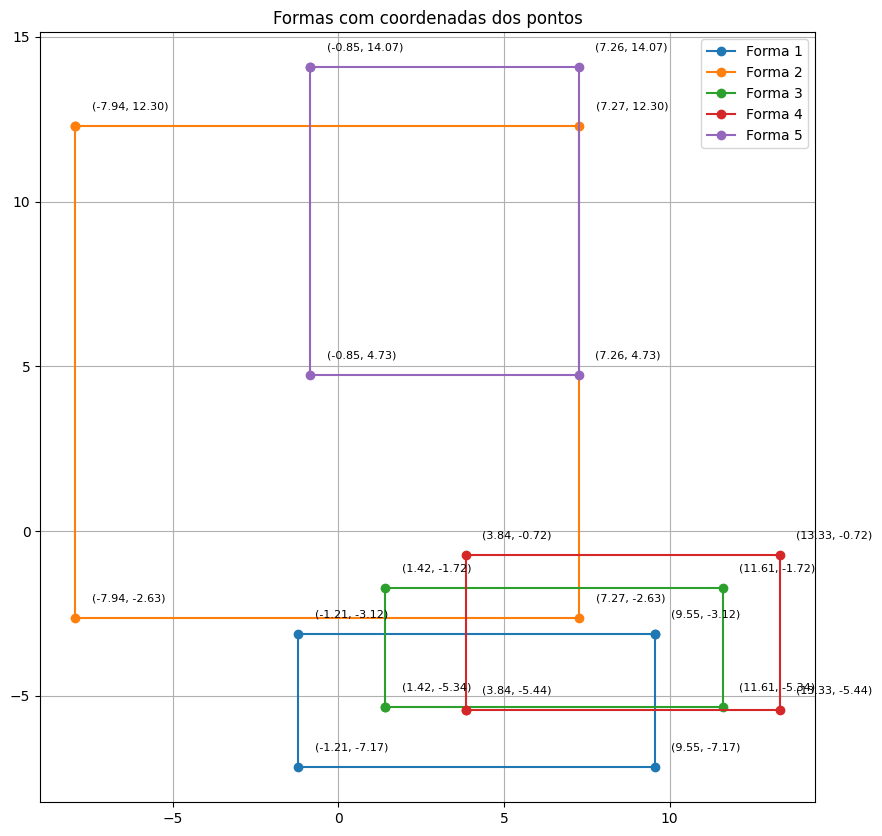

In [ ]:
import matplotlib.pyplot as plt

# Dados extraídos da imagem
arrays = loaded_array[:5]

plt.figure(figsize=(10, 10))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]

    # Plotando a forma
    plt.plot(x, y, marker='o', label=f'Forma {i+1}')
    
    # Adicionando coordenadas nos pontos
    for j in range(4):
        label = f'({x[j]:.2f}, {y[j]:.2f})'
        plt.text(x[j] + 0.5, y[j] + 0.5, label, fontsize=8, color='black')

plt.title('Formas com coordenadas dos pontos')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


In [ ]:
print(arrays[0][0:2])
print(arrays[0][2:4])

[ 9.551065  -1.2050222]
[-3.1208887 -7.169172 ]


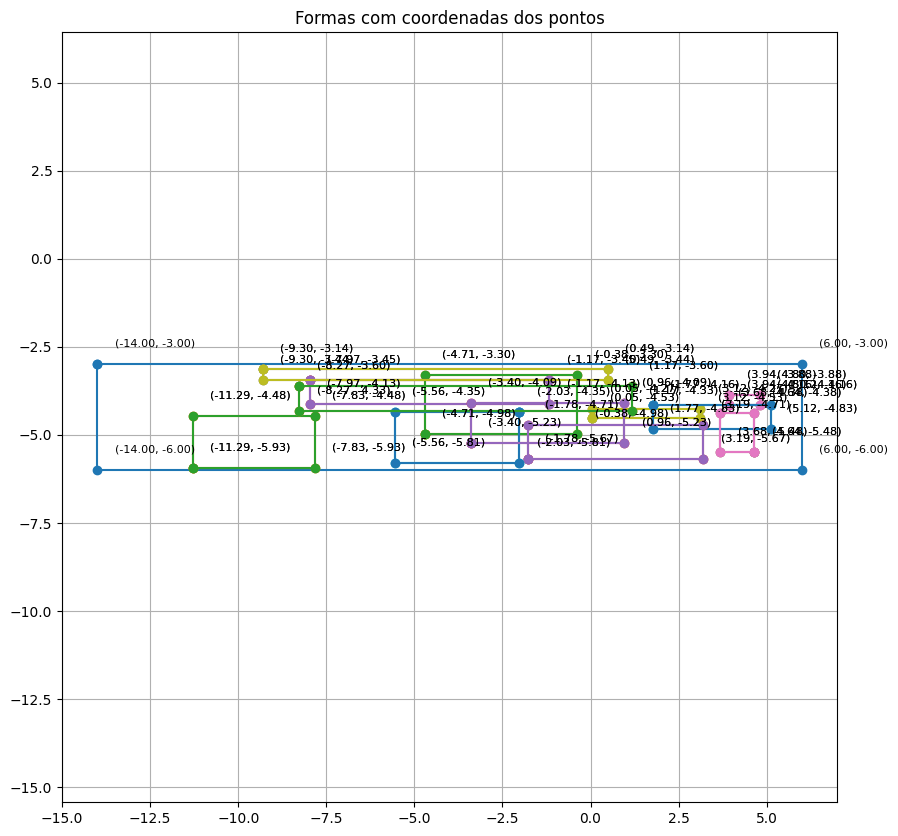

: 

In [ ]:

import matplotlib.pyplot as plt

# Dados extraídos da imagem
arrays = [
    [-14.0, 6.0, -3.0, -6.0],
           [ -4.70820427,  -0.3751936 ,  -4.98052692,  -3.3005743 ],
    [ -4.70820427,  -0.3751936 ,  -4.98052692,  -3.3005743 ],
    [ -7.96600962,  -1.17053676,  -3.44743323,  -4.12653065],
    [ -7.96600962,  -1.17053676,  -3.44743323,  -4.12653065],
    [  3.9398756 ,   4.79925823,  -4.1603961 ,  -3.876127  ],
    [  3.9398756 ,   4.79925823,  -4.1603961 ,  -3.876127  ],
    [  0.04889762,   3.11532354,  -4.52838707,  -4.26709557],
    [  0.04889762,   3.11532354,  -4.52838707,  -4.26709557],
    [  1.77036083,   5.11917877,  -4.16435385,  -4.82519531],
    [  1.77036083,   5.11917877,  -4.16435385,  -4.82519531],
    [-11.28748035,  -7.82873726,  -5.93424892,  -4.47715664],
    [-11.28748035,  -7.82873726,  -5.93424892,  -4.47715664],
    [ -1.7791841 ,   3.19362068,  -5.67335892,  -4.71134377],
    [ -1.7791841 ,   3.19362068,  -5.67335892,  -4.71134377],
    [  4.63837767,   3.68487978,  -5.47704077,  -4.38254738],
    [  4.63837767,   3.68487978,  -5.47704077,  -4.38254738],
    [ -9.30238914,   0.48636797,  -3.13787937,  -3.44380236],
    [ -9.30238914,   0.48636797,  -3.13787937,  -3.44380236],
    [ -2.02666306,  -5.55746317,  -4.3459301 ,  -5.81037998],
    [ -2.02666306,  -5.55746317,  -4.3459301 ,  -5.81037998],
    [ -8.26548767,   1.17463744,  -3.60119605,  -4.32761955],
    [ -8.26548767,   1.17463744,  -3.60119605,  -4.32761955],
    [ -3.39913177,   0.96075755,  -5.23282385,  -4.08835554],
    [ -3.39913177,   0.96075755,  -5.23282385,  -4.08835554]

       ]

plt.figure(figsize=(10, 10))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]

    # Plotando a forma
    plt.plot(x, y, marker='o', label=f'Valor {i+1}')
    
    # Adicionando coordenadas nos pontos
    for j in range(4):
        label = f'({x[j]:.2f}, {y[j]:.2f})'
        plt.text(x[j] + 0.5, y[j] + 0.5, label, fontsize=8, color='black')

plt.title('Formas com coordenadas dos pontos')
# plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()



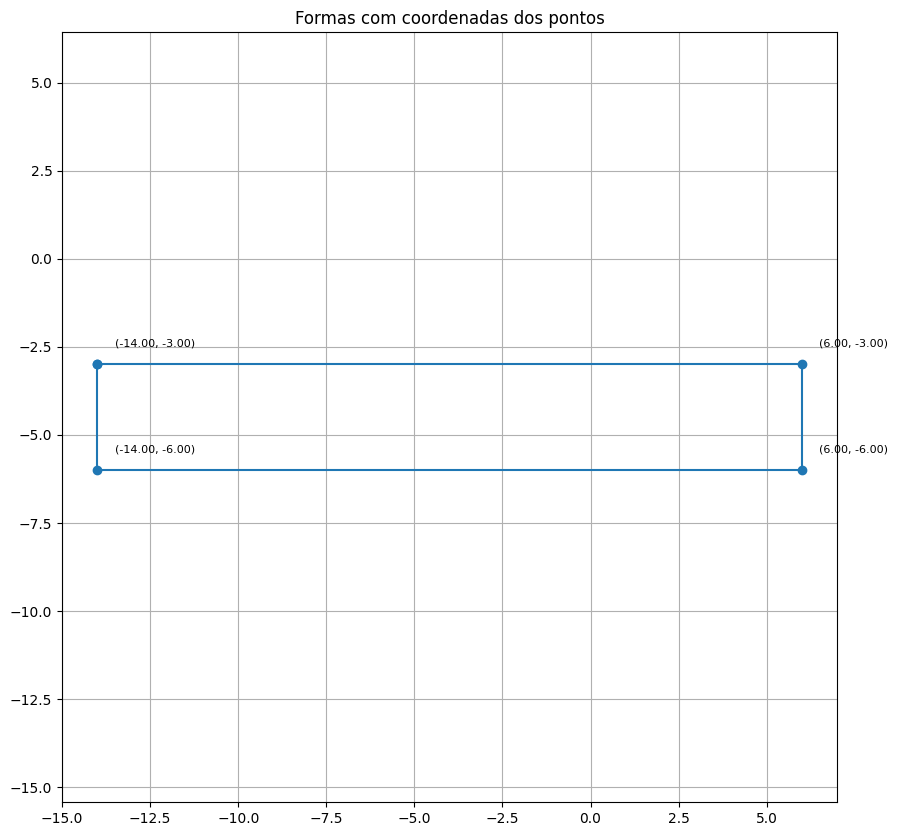

In [ ]:

import matplotlib.pyplot as plt

# Dados extraídos da imagem
arrays = arrays = [
    [-14.0, 6.0, -3.0, -6.0],
]

plt.figure(figsize=(10, 10))

for i, arr in enumerate(arrays):
    x1, x2, y1, y2 = arr
    # Canto inferior esquerdo, inferior direito, superior direito, superior esquerdo
    x = [x1, x2, x2, x1, x1]
    y = [y1, y1, y2, y2, y1]

    # Plotando a forma
    plt.plot(x, y, marker='o', label=f'Valor {i+1}')
    
    # Adicionando coordenadas nos pontos
    for j in range(4):
        label = f'({x[j]:.2f}, {y[j]:.2f})'
        plt.text(x[j] + 0.5, y[j] + 0.5, label, fontsize=8, color='black')

plt.title('Formas com coordenadas dos pontos')
# plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

